# __Библиотеки и константы__

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_regression, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor, cv
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from scipy.stats import t, f
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# __Датасет__

In [15]:
df = pd.read_excel('dataset_renamed.xlsx')

In [16]:
df

,id,target,Расстояние до метро,"Суммарное кол-во отзывов в категории ""АЗС"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Алкомаркеты"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Аптеки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Банки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Бизнес_центры"" в радиусе 150м","Суммарное кол-во отзывов в категории ""ВУЗы"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Вокзалы"" в радиусе 150м",...,Суммарный вечерний трафик сигналов рабочих в радиусе 140м,Суммарный трафик сигналов рабочих в радиусе 140м,Суммарный утренний трафик юзеров рабочих в радиусе 140м,Суммарный дневной трафик юзеров рабочих в радиусе 140м,Суммарный вечерний трафик юзеров рабочих в радиусе 140м,Суммарный трафик юзеров рабочих в радиусе 140м,Тип БЦ,Тип хаб,Тип улица,Тип ТЦ
0,60,1.292717,5526.692151,0,274,56,156,249,0,0,...,33,187,3,6,3,6,0,0,1,0
1,50,1.674569,16243.183872,0,0,719,402,0,0,0,...,303,1302,9,12,11,15,0,0,0,1
2,17,1.140666,6401.230357,0,194,425,271,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,15,1.352501,2255.498620,0,0,0,0,1737,83,0,...,52,315,6,7,5,10,0,0,1,0
4,74,1.324726,5811.209297,0,0,71,0,0,0,0,...,257,1189,2,2,2,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,112,NaN,19887.712950,0,0,193,32,0,0,0,...,185,1074,6,6,7,8,0,0,0,1
94,117,NaN,485.615204,0,1258,237,103,372,60,0,...,351,1529,9,10,10,13,0,0,1,0
95,126,NaN,2420.989438,0,146,346,16,20,0,0,...,129,437,8,10,6,14,0,0,1,0
96,144,NaN,11997.377318,0,85,414,547,0,0,0,...,91,309,10,10,9,12,0,0,1,0


In [17]:
df.shape

(98, 2335)

__Описание датасета:__
* Идентификатор (id).
* Расстояние до метро.
* Набор признаков, характеризующих окружающие кофейню объекты различных категорий в указанном радиусе относительно кофейни: количество отзывов, количество объектов, средний рейтинг объектов. В категорию «Кофейни» в данных признаках рассматриваемая кофейня не включается.
* Набор признаков, характеризующих интенсивность транспортных и пешеходных потоков в указанном радиусе или пешей доступности относительно кофейни. Интенсивность рассчитана отдельно для пешеходов, автомобилей, суммы первых и вторых; для разного времени суток (утро, день, вечер, весь день); для числа сигналов и числа пользователей (юзеров); для резидентов района, в котором находится рассматриваемая кофейня, и для работников этого района.
Набор признаков, характеризующих жилые дома в указанном радиусе или пешей доступности относительно кофейни. Данные признаки рассчитываются отдельно для числа квартир и цены квадратного метра.
* Набор признаков, характеризующих мобильный трафик в указанном радиусе относительно кофейни. Данные признаки рассчитываются отдельно для групп, разделенных по возрасту и доходу, а также для типов трафика для района, где расположена рассматриваемая кофейня (домашний, рабочий, транзитный, длительный, их сумма).
* Набор признаков, характеризующих тип кофейни. Данная бинарная переменная определяется специфическим расположением кофейни (в бизнес-центре, в крупном транспортном узле (хаб), в любом здании кроме бизнес-центра и торгового центра (улица), в торговом ц

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Columns: 2335 entries, id to Тип ТЦ
dtypes: float64(1182), int64(1153)
memory usage: 1.7 MB


Все признаки, представленные в датасете, либо вещественные - float64, либо целые - int64.

__Предварительно разделим датасет на тестовый тренировочный.__

In [19]:
condition = (df.target.isna())
test, train = df[condition], df[~condition]

## __Подготовка датасета__

### __Работа с пропусками__

Найдем пропуски в датасете:

In [20]:
na = df.isnull().mean() * 100
threshold = 30
count_more_threshold  = 0
count_less_threshold  = 0
columns_to_drop = []
for column in df.columns:
    if na[column] >= threshold:
        count_more_threshold  += 1
        columns_to_drop.append(column)
    if na[column] < threshold:
        count_less_threshold  += 1
print(f'Количество признаков, в которых пропусков >= {threshold }%: {count_more_threshold}')
print(f'Количество признаков, в которых пропусков < {threshold }%: {count_less_threshold}')

Количество признаков, в которых пропусков >= 30%: 335
Количество признаков, в которых пропусков < 30%: 2000


Удалим данные, в которых процентное соотношение пропусков больше чем указанный выше порог.

In [21]:
test = test.drop(columns=columns_to_drop)
train = train.drop(columns=columns_to_drop)

В оставшихся признаках заменим пропуски средним значением для вещественных признаков. И модой для категориальных.

In [22]:
binary  = ('Тип БЦ', 'Тип хаб', 'Тип улица', 'Тип ТЦ')
real = list(set(train.columns) - set(binary))

In [23]:
for r in real:  
    # замена на среднее 
    train[r] = train[r].fillna(train[r].mean())
    test[r] = test[r].fillna(train[r].mean())
for b in binary:
    # замена модой 
    train[b] = train[b].fillna(train[b].value_counts().index[0])
    test[b] = test[b].fillna(train[b].value_counts().index[0])


### __Удаление неинформативных столбцов__

__Также удалим те признаки, обладающие нулевой дисперсией. То есть каждый объект в выборке имеет псевдо константное значение на этом признаке.__

In [24]:
null_list = []
for item in train.columns:
    if train[item].var() == 0:
        null_list.append(item)
train = train.drop(columns=null_list)
test = test.drop(columns=null_list)

__Удалим id, так как он не влияет на принятие решений.__

In [25]:
train = train.drop(columns='id')
test = test.drop(columns='id')

__Удаляем дубликаты__

In [26]:
test = test.drop(columns=list(set(train.T[0].index) - set(train.T.drop_duplicates()[0].index)))
train = train.T.drop_duplicates().T

__И, наконец, для удобства разобьем tarin на матрицу вещественных признаков, матрицу категориальных признаков и вектор таргетной переменной__:

In [27]:
binary  = ['Тип БЦ', 'Тип хаб', 'Тип улица', 'Тип ТЦ']
real = list(set(train.columns) - set(binary))
y = train.target
x_real = train[real]
x_real = x_real.drop(columns='target')
x_cat = train[binary]
x_real_test = test[real]
x_real_test = x_real_test.drop(columns='target')
x_cat_test = test[binary]

### __Работа с выбросами__

__Применим интерквантильный размах, чтобы найти выбросы и заменить их на среднее.__

In [28]:
def quantile_range(feature):
    Q1 = feature.quantile(0.25)
    Q3 = feature.quantile(0.75)
    IQR = feature.quantile(0.75) - feature.quantile(0.25)
    low_bound  = Q1 - 1.5*IQR
    high_bound = Q3 + 1.5*IQR
    return low_bound, high_bound

def drop_outlier(df, column_name, logarithmizing=False, feature_range_type=quantile_range):
    feature = df[column_name]
    if logarithmizing:
        feature = np.log(feature + 1)
        
    low_bound, high_bound = feature_range_type(feature) 
    df.loc[((feature < low_bound) | (feature > high_bound)), column_name] = df[column_name].mean()
    return df

In [29]:
for column in x_real.columns:
    x_real = drop_outlier(x_real, column_name=column)

# __Отбор признаков__

__Так как признаков после предварительной обработки датасета осталось много (порядка 1500), что много больше объема выборки. Проведем отбор признаков, на основе самых важных построим гипотезы и обучаем модель машинного обучения. Отбор признаков проведем в три этапа:__
* Удалим коррелированные признаки
* Одномерный отбор, чтобы получить ~50 самых важных признаков.
* Среди ~50 признаков используем оберточную модель и, таким образом, выделим самые важные.

## __Корреляции__ 

__Удалим признаки, которые сильно коррелирует между собой (кореляция спирмана > 0.75)__ 

Категориальные признаки:

In [30]:
correlation_matrix_cat = x_cat.corr(method='spearman')
correlated_features_cat = list()

for column in range(len(correlation_matrix_cat.columns)):
    for item in range(column):
        if abs(correlation_matrix_cat.iloc[column, item]) > 0.75:
            colname = correlation_matrix_cat.columns[column]
            correlated_features_cat.append(colname)

Вещественные признаки:

In [31]:
correlation_matrix_real = x_real.corr(method='spearman')
correlated_features_real = list()

for column in tqdm(range(len(correlation_matrix_real.columns))):
    for item in range(column):
        if abs(correlation_matrix_real.iloc[column, item]) > 0.75:
            colname = correlation_matrix_real.columns[column]
            correlated_features_real.append(colname)

100%|██████████| 1591/1591 [00:29<00:00, 53.39it/s] 


In [32]:
x_cat = x_cat.drop(columns=correlated_features_cat)
x_real = x_real.drop(columns=correlated_features_real)
x_cat_test = x_cat_test.drop(columns=correlated_features_cat)
x_real_test = x_real_test.drop(columns=correlated_features_real)

## __Отбор вещественных признаков__

### __Одномерный отбор__

__Для вещественных признаков воспользуемся критерием взаимной информации с таргетом:__

In [33]:
m_info = mutual_info_regression(X=x_real, y=y)
m_info = pd.Series(m_info)
m_info.index = x_real.columns

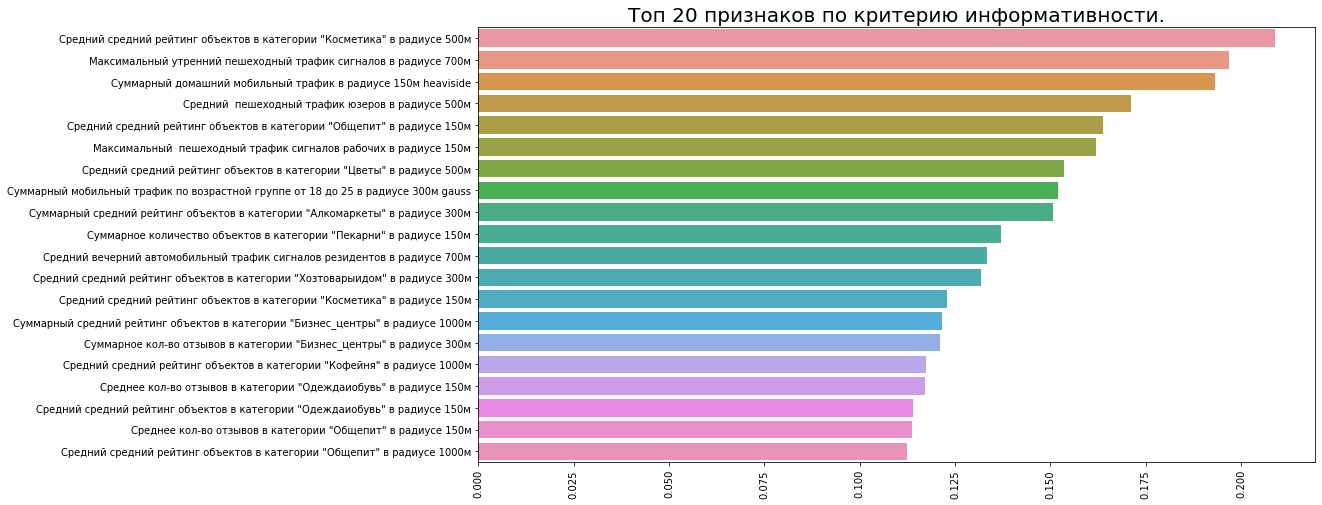

In [34]:
plt.figure(figsize=(15, 8))
plt.title('Топ 20 признаков по критерию информативности.', fontsize=20)
sns.barplot(x=m_info.sort_values(ascending=False)[:20].values, y=m_info.sort_values(ascending=False)[:20].index)
plt.xticks(rotation=90)
plt.show()

In [35]:
select_mutual_info_real = SelectPercentile(mutual_info_regression, percentile=25)
select_mutual_info_real.fit(X=x_real, y=y)
x_real = pd.DataFrame(
    data=select_mutual_info_real.transform(x_real), 
    columns=x_real.columns[select_mutual_info_real.get_support()]
    )
x_real_test = pd.DataFrame(
    data=select_mutual_info_real.transform(x_real_test), 
    columns=x_real_test.columns[select_mutual_info_real.get_support()]
    )

### __Оберточная модель:__

__Воспользуемся прямым алгоритмом, для отбора важных признаков. Тут градиентный бустинг является моделью, с помощью которой проводится оценка.__

In [36]:
scoring_array = np.array([])
for n in tqdm(range(10, 60, 10)):   
    sfs = SequentialFeatureSelector(estimator=GradientBoostingRegressor(random_state=51), 
        forward=True, 
        cv=3,
        scoring='neg_root_mean_squared_error',
        k_features=n,
        verbose=0,
        n_jobs=-1

    )
    sfs.fit(X=x_real, y=y, custom_feature_names=x_real.columns)
    scoring_array = np.append(scoring_array, -sfs.k_score_)

100%|██████████| 5/5 [03:27<00:00, 41.46s/it]


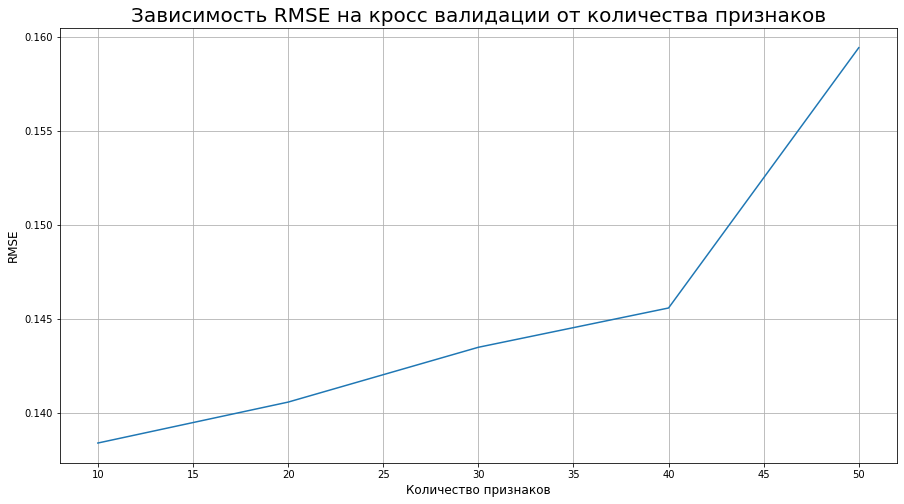

In [37]:
plt.figure(figsize=(15, 8))
plt.title('Зависимость RMSE на кросс валидации от количества признаков', fontsize=20)
plt.grid(True)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
sns.lineplot(x=range(10, 60, 10), y=scoring_array)
plt.show()

__Получим, что для 20~40 признаков являются самыми информативными для нашей модели__

In [38]:
sfs_30 = SequentialFeatureSelector(estimator=GradientBoostingRegressor(), 
        forward=True, 
        cv=3,
        scoring='neg_root_mean_squared_error',
        k_features=30,
        verbose=0,
        n_jobs=-1

)
sfs_30.fit(X=x_real, y=y, custom_feature_names=x_real.columns)

SequentialFeatureSelector(cv=3, estimator=GradientBoostingRegressor(),
                          k_features=30, n_jobs=-1,
                          scoring='neg_root_mean_squared_error')

__Запишем эти признаки в отдельный дата фрейм__

In [39]:
importan_features = []
for i in (sfs_30.k_feature_idx_):
    importan_features.append(x_real.columns[i])

In [40]:
x_real_selected = pd.DataFrame(data=x_real[importan_features])
x_real_test_selected = pd.DataFrame(data=x_real_test[importan_features])

__Выведем эти признаки и их важность:__

In [41]:
perm = permutation_importance(GradientBoostingRegressor().fit(x_real_selected, y), x_real_selected, y, n_repeats=30, random_state=51)
perm_df = pd.DataFrame((perm['importances_mean'], x_real_selected.columns), index=('Score', 'Features'))
perm_df = perm_df.T
perm_df = perm_df.sort_values(ascending=False, by='Score')

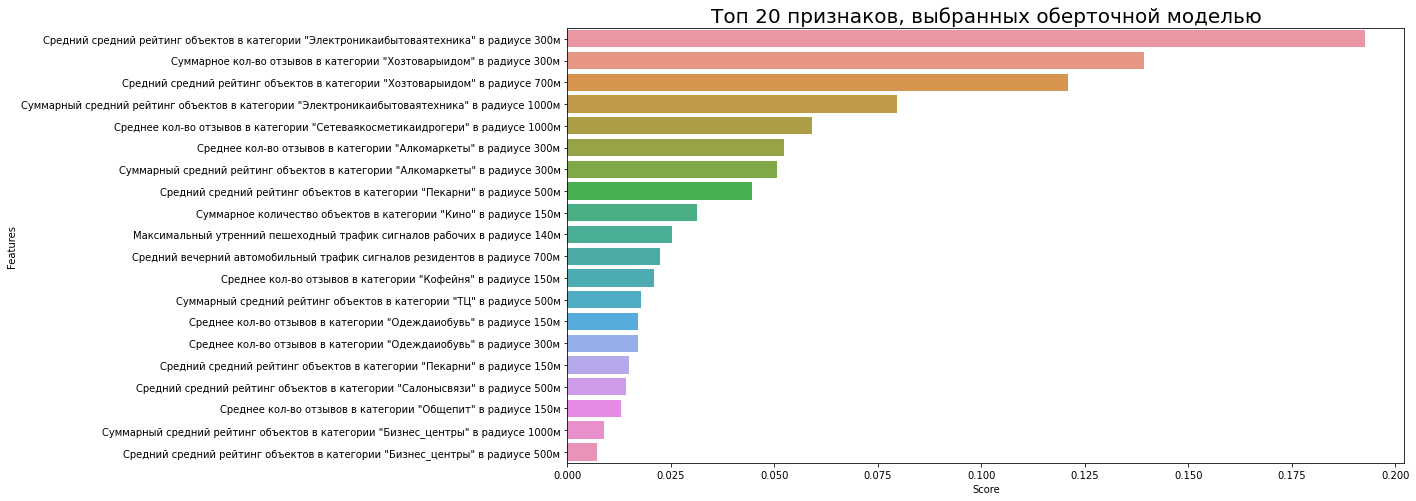

In [42]:
plt.figure(figsize=(15, 8))
sns.barplot(y="Features", x="Score", data=perm_df[:20])
plt.title('Топ 20 признаков, выбранных оберточной моделью', fontsize=20)
plt.show()

### __Промежуточные выводы/гипотезы на основе одномерного и многомерного анализа:__
*   __Рейтинг каких-либо объектов в категории превалирует над количеством этих объектов. Поэтому в первую очередь нужно смотреть на качество услуг, которые предоставляют объекты в ближайшем окружении.__
*   __Исходя из списка важных категорий: хоз. товары, электроника и бытовая техника, косметика, одежда и обувь, можно предположить, что существенная часть посетителей женщины/домохозяйки в возрасте ~18-25 лет.__
*   __Наличие таких категорий, как: пекарни, сетевые продукты  и общепит говорит о том, что покупка кофе происходит вместе с приемом пищи. Поэтому кофейни нужно располагать как можно ближе/дальше (в зависимости от корреляции с таргетом) от продуктовых точек.__
*    __Также из среднего трафика можно определить, что самые прибыльные часы днем и утром.__
    

## __Важность категориальных признаков__

__Так как категориальных признаков немного, воспользуемся взаимной информацией с таргетом.__ 

In [43]:
perm_cat = mutual_info_regression( x_cat, y)
perm_df_cat = pd.DataFrame((perm['importances_mean'], x_cat.columns), index=('Score', 'Features'))
perm_df_cat = perm_df_cat.T
perm_df_cat = perm_df_cat.sort_values(ascending=False, by='Score')

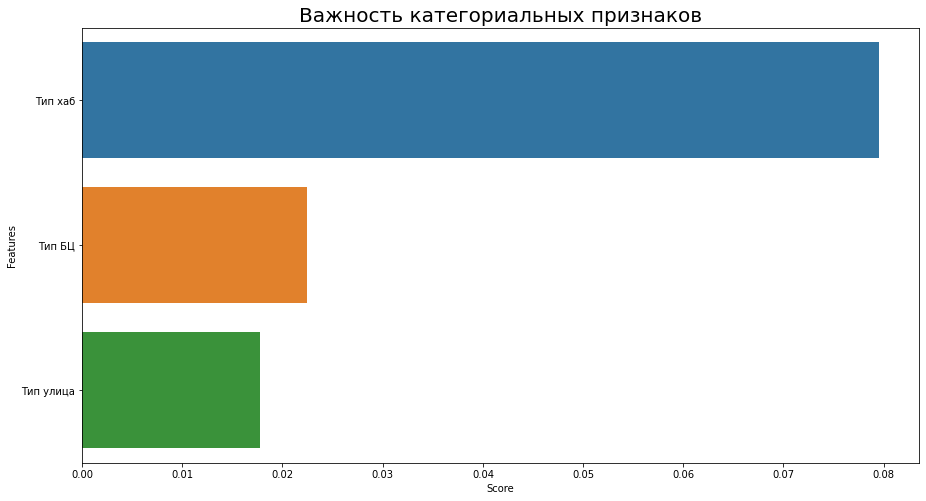

In [44]:
plt.figure(figsize=(15, 8))
sns.barplot(y="Features", x="Score", data=perm_df_cat)
plt.title('Важность категориальных признаков', fontsize=20)
plt.show()

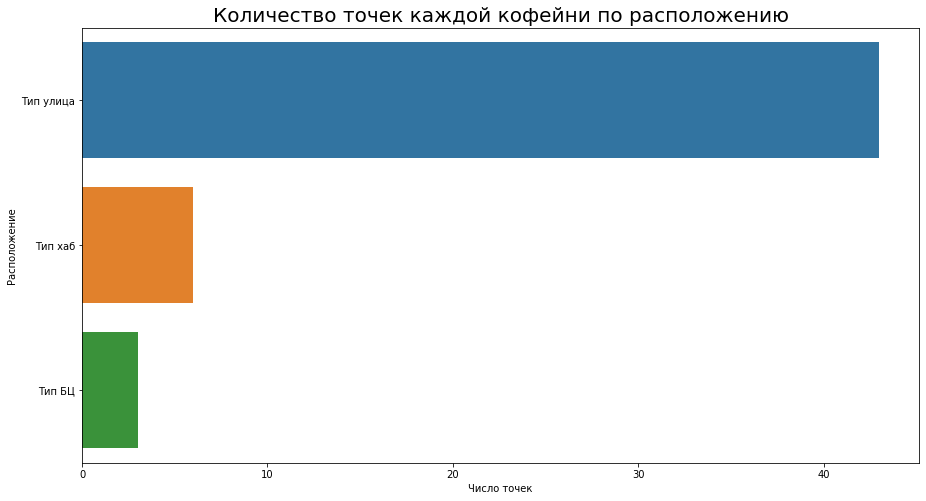

In [45]:
location = pd.DataFrame((x_cat.sum().values, x_cat.sum().index), index=('Число точек', 'Расположение'))
location = location.T
location = location.sort_values(ascending=False, by='Число точек')
plt.figure(figsize=(15, 8))
sns.barplot(x='Число точек', y='Расположение', data=location)
plt.title('Количество точек каждой кофейни по расположению', fontsize=20)
plt.show()

__Важность информации о расположении кофейни на улице преобладает над БЦ, ТЦ и хабом, но, стоит отметить, что количество кофеен, расположенных на улице и в тц на порядок больше.__

# __Анализ зависимостей важных признаков и таргета__

## __Вещественные признаки__

__Для проверки гипотез и уточнений выводов построим зависимости важных признаков от целевой переменной для 9 категорий из одномерного отбора.__

In [46]:
category = ('Косметика', 'Электроникаибытоваятехника', 'Пекарни', 'Цветы', 'Одеждаиобувь', 'утренний трафик', 'Пунктывыдачи', 'Салонысвязи', 'Общепит')

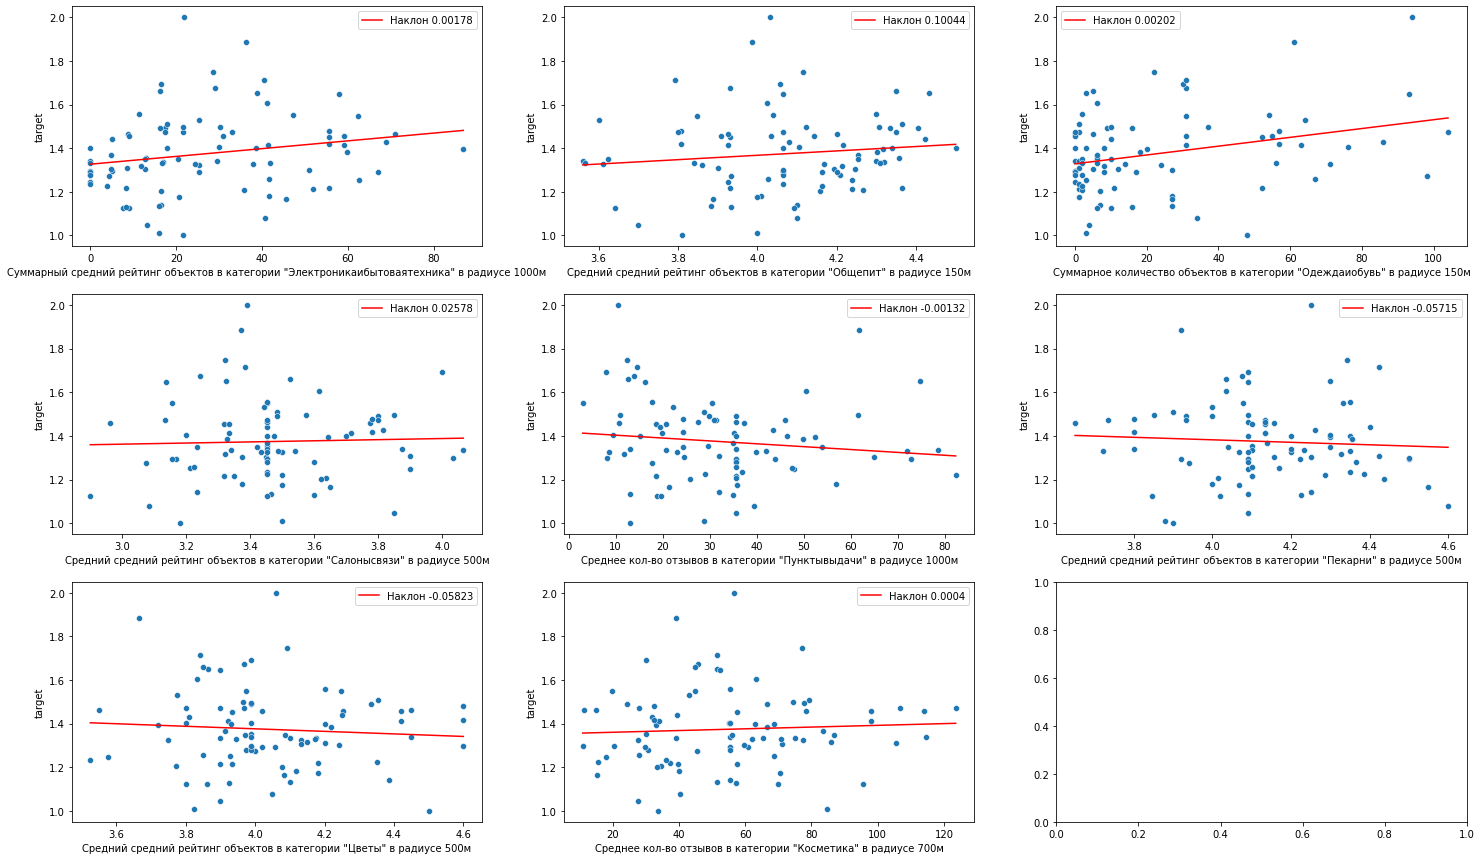

In [47]:
one_dim_important_features = []
for f in x_real.columns:
    for cat in category:
        if (cat in f) and (cat not in ''.join(one_dim_important_features)):
            one_dim_important_features.append(f)
    if len(one_dim_important_features) == 9:
        break

fig = plt.figure(figsize=(25, 15))
ax_array = []

for i in range(1, 10):
    ax_array.append(fig.add_subplot(3, 3, i))

for i, ax in zip(range(len(one_dim_important_features)), ax_array):
    feature = x_real[one_dim_important_features[i]]
    X = pd.DataFrame(data={'1' : feature.values, '2': np.ones(shape=88)})
    lr = LinearRegression().fit(X, y)
    f = lambda x: lr.coef_[0]*x + lr.intercept_
    x = np.linspace(feature.values.min(), feature.values.max(), 5)
    sns.scatterplot(x=feature, y=y, ax=ax)
    sns.lineplot(x=x, y=f(x), color='red', label=f'Наклон {round(lr.coef_[0], 5)}', ax=ax)
    ax.legend()

plt.show()

### __F-тест для проверки значимости линейной регрессии__

In [48]:
for i in range(len(one_dim_important_features)):
    feature = x_real[one_dim_important_features[i]]
    X = np.array(pd.DataFrame(data={'1' : np.log(feature.values+1), '2': np.ones(shape=88)}))
    f, p = f_regression(X, (y))
    print(one_dim_important_features[i] + ':')
    if p[0] > 0.05:
        print(f'p_value для категории: {p[0]} > alpha = 0.05 -')
    else:
        print(f'p_value для категории: {p[0]} < alpha = 0.05 +')

Суммарный средний рейтинг объектов в категории "Электроникаибытоваятехника" в радиусе 1000м:
p_value для категории: 0.027641515166303265 < alpha = 0.05 +
Средний средний рейтинг объектов в категории "Общепит" в радиусе 150м:
p_value для категории: 0.2696527901945144 > alpha = 0.05 -
Суммарное количество объектов в категории "Одеждаиобувь" в радиусе 150м:
p_value для категории: 0.022113402557315955 < alpha = 0.05 +
Средний средний рейтинг объектов в категории "Салонысвязи" в радиусе 500м:
p_value для категории: 0.7387203498862065 > alpha = 0.05 -
Среднее кол-во отзывов в категории "Пунктывыдачи" в радиусе 1000м:
p_value для категории: 0.04698306262624311 < alpha = 0.05 +
Средний средний рейтинг объектов в категории "Пекарни" в радиусе 500м:
p_value для категории: 0.5864924254486423 > alpha = 0.05 -
Средний средний рейтинг объектов в категории "Цветы" в радиусе 500м:
p_value для категории: 0.49905564433694416 > alpha = 0.05 -
Среднее кол-во отзывов в категории "Косметика" в радиусе 700м:

### __Выводы:__
__Из приведенных выше графиков и f-критерия следует, что с ростом количества объектов "Электроника и бытовая техника" и "Пункты выдачи" растет и таргет, тоже мы можем сказать и для продуктовых точек и утреннего трафика, но с меньшей уверенностью.__
  

## __Категориальные признаки__

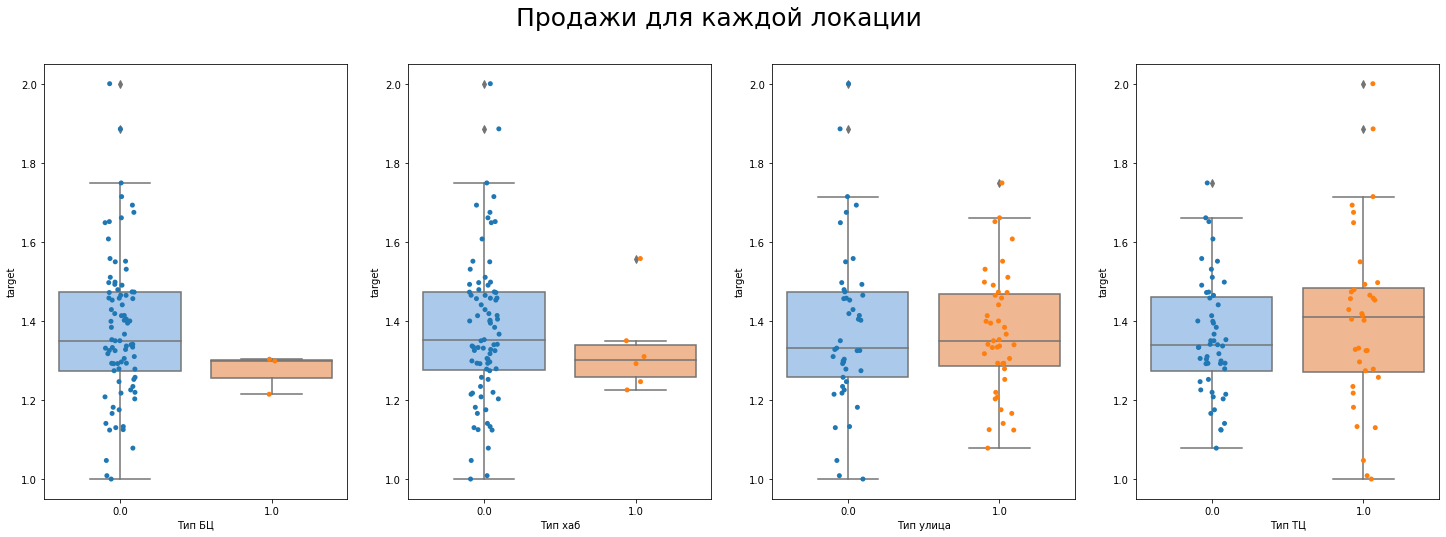

In [49]:
fig = plt.figure(figsize=(25, 8))
ax_1 = fig.add_subplot(1, 4, 1)
ax_2 = fig.add_subplot(1, 4, 2)
ax_3 = fig.add_subplot(1, 4, 3)
ax_4 = fig.add_subplot(1, 4, 4)
fig.suptitle('Продажи для каждой локации', fontsize=25)
for ax, cat in zip((ax_1, ax_2, ax_3, ax_4), binary):
    sns.boxplot(x=train[cat], y=y, palette='pastel', ax=ax)
    sns.stripplot(x=train[cat], y=y, ax=ax)
plt.show()

### __Вывод:__
__Ни для одной из представленных локации по имеющимся данным нельзя сказать, где продажи больше: в локации (1) илл вне локации (0).__

# __Модель машинного обучения__

__Для решения поставленной задачи воспользуемся градиентным бустингом, реализованным в библиотеке Catboost.__

In [65]:
catboostreg = CatBoostRegressor(loss_function='MAPE', verbose=0, task_type="GPU")

## __PCA__

__Применим метод главных компонент для понижения размерности, чтобы, возможно, улучшить метрику на сырой модели.__

In [66]:
result = []
for n in tqdm(range(5, 35, 5)): 
    decomposer = PCA(n_components=n)
    x_dec = decomposer.fit_transform(x_real_selected)
    xtotrain = np.hstack((x_dec, x_cat.values))
    cvs = -cross_val_score(estimator=catboostreg, X=xtotrain, y=y, cv=3, scoring='neg_mean_absolute_percentage_error')
    result.append(cvs*100)

100%|██████████| 6/6 [04:28<00:00, 44.77s/it]


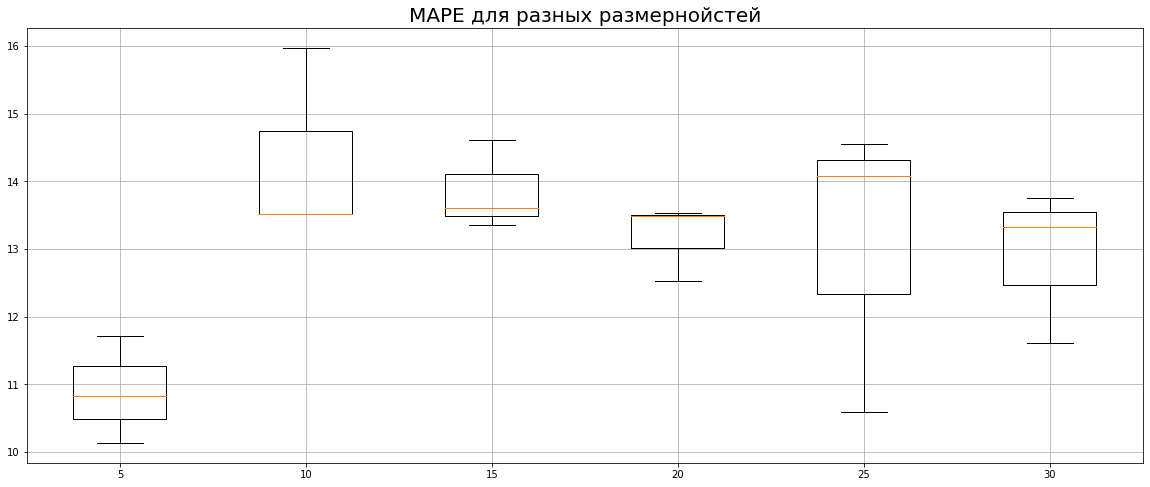

In [67]:
plt.figure(figsize=(20, 8))
plt.grid(True)
plt.boxplot(result, labels=range(5, 35, 5))
plt.title('MAPE для разных размернойстей', fontsize=20)
plt.show()

__Из графика видно, что оптимальная размерность для исходных данных: 25__

In [127]:
decomposer = PCA(n_components=25)
x_dec = decomposer.fit_transform(x_real_selected)
x_dec_test = decomposer.transform(x_real_test_selected)
x_catboost = pd.concat([pd.DataFrame(data=x_dec), x_cat], axis=1)
x_catboost_test = pd.concat([pd.DataFrame(data=x_dec_test), x_cat_test.reset_index(drop=True)], axis=1)

In [93]:
catboostreg = CatBoostRegressor(loss_function='MAPE', verbose=0, task_type="GPU")

## __Подбор гипер параметров__

__Подбор гипер параметров будет происходить по сетке__

In [98]:
grid = {'iterations': [100, 500, 700, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 5, 6],
        'l2_leaf_reg': [3, 4, 6],
        'subsample': [0.5, 1],
        'bootstrap_type': ['Bernoulli'],
        'rsm': [0.5, 1]
        }

In [99]:
grid_search_result = catboostreg.grid_search(grid, X=x_catboost, y=y, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.5383400917
bestIteration = 99
bestTest = 0.1511205567
bestIteration = 83
bestTest = 0.1263789071
bestIteration = 31
bestTest = 0.1536042823
bestIteration = 355
bestTest = 0.1091339456
bestIteration = 360
bestTest = 0.1263789071
bestIteration = 31
bestTest = 0.1536042823
bestIteration = 355
bestTest = 0.1091339456
bestIteration = 360
bestTest = 0.1263789071
bestIteration = 31
bestTest = 0.1536042823
bestIteration = 355
bestTest = 0.1023040811
bestIteration = 759
bestTest = 0.1263789071
bestIteration = 31
Training on fold [0/3]
bestTest = 0.09852453868
bestIteration = 58
Training on fold [1/3]
bestTest = 0.1161149946
bestIteration = 41
Training on fold [2/3]
bestTest = 0.1138583956
bestIteration = 46


__Набор лучших параметров:__

In [100]:
grid_search_result['params']

{'rsm': 1,
 'depth': 4,
 'l2_leaf_reg': 3,
 'iterations': 2000,
 'subsample': 0.5,
 'learning_rate': 0.05,
 'bootstrap_type': 'Bernoulli'}

In [144]:
best_gbr = CatBoostRegressor(iterations=2000,
    loss_function='MAPE', 
    verbose=0, 
    task_type='GPU',
    depth=4,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',
    learning_rate=0.01,
    subsample=0.5,
    rsm=1,
)

In [145]:
cvs = -cross_val_score(estimator=best_gbr, X=x_catboost, y=y, cv=3, scoring='neg_mean_absolute_percentage_error')
print(f'MAPE: {100 * cvs.mean()} %')

MAPE: 10.686061590470551 %


In [132]:
best_gbr.fit(X=x_catboost, y=y)
results = pd.DataFrame(data=best_gbr.predict(x_catboost_test), columns=['target'])
results.to_csv('results.csv') 

In [142]:
results

,target
0,1.590209
1,1.584017
2,1.553108
3,2.243026
4,1.190533
5,1.543050
6,1.411934
7,1.587521
8,1.244504
9,1.713940


# __Итог:__
* Произведена подготовка датасета(очистка пропусков, выбросов и столбцов с нулевой дисперсией);
* Отобраны самые информативные признаки (удаление признаков с высокой корреляцией, одномерный отбор, отбор  жадными моделями);
* Построены зависимости таргета от самых информативных признаков, проведен регрессионный анализ, сделаны выводы;
* Построена модель машинного обучения на основе градиентного бустинга;
* Для оптимальных гипер параметров, полученных перебором по сетке, посчитана метрика MAPE на кросс валидации;
* __MAPE: 10.6 %__